# Session 5: ARIMA Models - Advanced Topics

## Summer School: Time Series Methods for Finance and Economics

### Learning Objectives

By the end of this session, you will be able to:
1. Specify and estimate Seasonal ARIMA (SARIMA) models
2. Identify seasonal patterns using ACF/PACF
3. Apply automatic model selection procedures
4. Use information criteria for model comparison
5. Generate long-horizon forecasts with prediction intervals
6. Handle outliers and structural breaks
7. Implement ARIMAX models with exogenous variables
8. Apply advanced diagnostics and model validation

### Prerequisites
- Session 4: ARIMA Models - Fundamentals
- Understanding of Box-Jenkins methodology
- Knowledge of ACF/PACF interpretation

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 4)

## 1. Seasonal ARIMA (SARIMA) Models

### 1.1 The Need for Seasonal Models

Many economic and business time series exhibit **seasonality**:
- Retail sales peak during holidays
- Energy consumption varies with weather
- Tourism follows vacation patterns
- Agricultural production has harvest cycles

Standard ARIMA models cannot adequately capture these patterns.

### 1.2 SARIMA(p,d,q)(P,D,Q)ₛ Specification

A **Seasonal ARIMA** model combines:
- **Non-seasonal components**: (p,d,q)
- **Seasonal components**: (P,D,Q) with period s

**General form**:
$$\phi_p(L)\Phi_P(L^s)(1-L)^d(1-L^s)^D y_t = \theta_q(L)\Theta_Q(L^s)\epsilon_t$$

where:
- $\phi_p(L)$: Non-seasonal AR polynomial of order p
- $\Phi_P(L^s)$: Seasonal AR polynomial of order P
- $(1-L)^d$: Non-seasonal differencing
- $(1-L^s)^D$: Seasonal differencing
- $\theta_q(L)$: Non-seasonal MA polynomial of order q
- $\Theta_Q(L^s)$: Seasonal MA polynomial of order Q
- $s$: Seasonal period (e.g., 12 for monthly, 4 for quarterly)

### 1.3 Common SARIMA Models

**Example 1**: SARIMA(0,1,1)(0,1,1)₁₂
$$\nabla\nabla_{12}y_t = (1+\theta_1 L)(1+\Theta_1 L^{12})\epsilon_t$$

This is the "airline model" - very popular for monthly data.

**Example 2**: SARIMA(1,0,0)(1,0,0)₄
$$y_t = \phi_1 y_{t-1} + \Phi_1 y_{t-4} - \phi_1\Phi_1 y_{t-5} + \epsilon_t$$

Quarterly data with both non-seasonal and seasonal AR.

### 1.4 Seasonal Differencing

**Seasonal difference** at lag s:
$$\nabla_s y_t = y_t - y_{t-s}$$

**When to use**:
- ACF has significant spikes at seasonal lags (s, 2s, 3s, ...)
- Slow decay at seasonal lags
- Visual inspection shows repeating patterns

In [4]:
# Download monthly data with clear seasonality
print("Downloading monthly airline passenger data...")

try:
    # Try to get real data
    import pandas_datareader as pdr
    airline = pdr.get_data_fred('RSXFS', start='2010-01-01', end='2023-12-01')
    airline = airline['RSXFS'].dropna()
    data_source = "US Retail Sales"
except:
    # Generate synthetic seasonal data
    print("Generating synthetic seasonal data...")
    T = 168  # 14 years monthly
    t = np.arange(T)
    trend = 300 + 2 * t
    seasonal = 50 * np.sin(2 * np.pi * t / 12) + 30 * np.cos(2 * np.pi * t / 12)
    noise = np.random.normal(0, 10, T)
    airline = pd.Series(
        trend + seasonal + noise,
        index=pd.date_range(start='2010-01-01', periods=T, freq='MS'),
        name='Passengers'
    )
    data_source = "Simulated Data"

print(f"\nData: {data_source}")
print(f"Period: {airline.index[0].date()} to {airline.index[-1].date()}")
print(f"Observations: {len(airline)}")
print(f"Frequency: Monthly")

# Split into train and test
train_size = int(len(airline) * 0.85)
train = airline[:train_size]
test = airline[train_size:]

print(f"\nTraining size: {len(train)}")
print(f"Test size: {len(test)}")


Data: US Retail Sales
Period: 2010-01-01 to 2023-12-01
Observations: 168
Frequency: Monthly

Training size: 142
Test size: 26


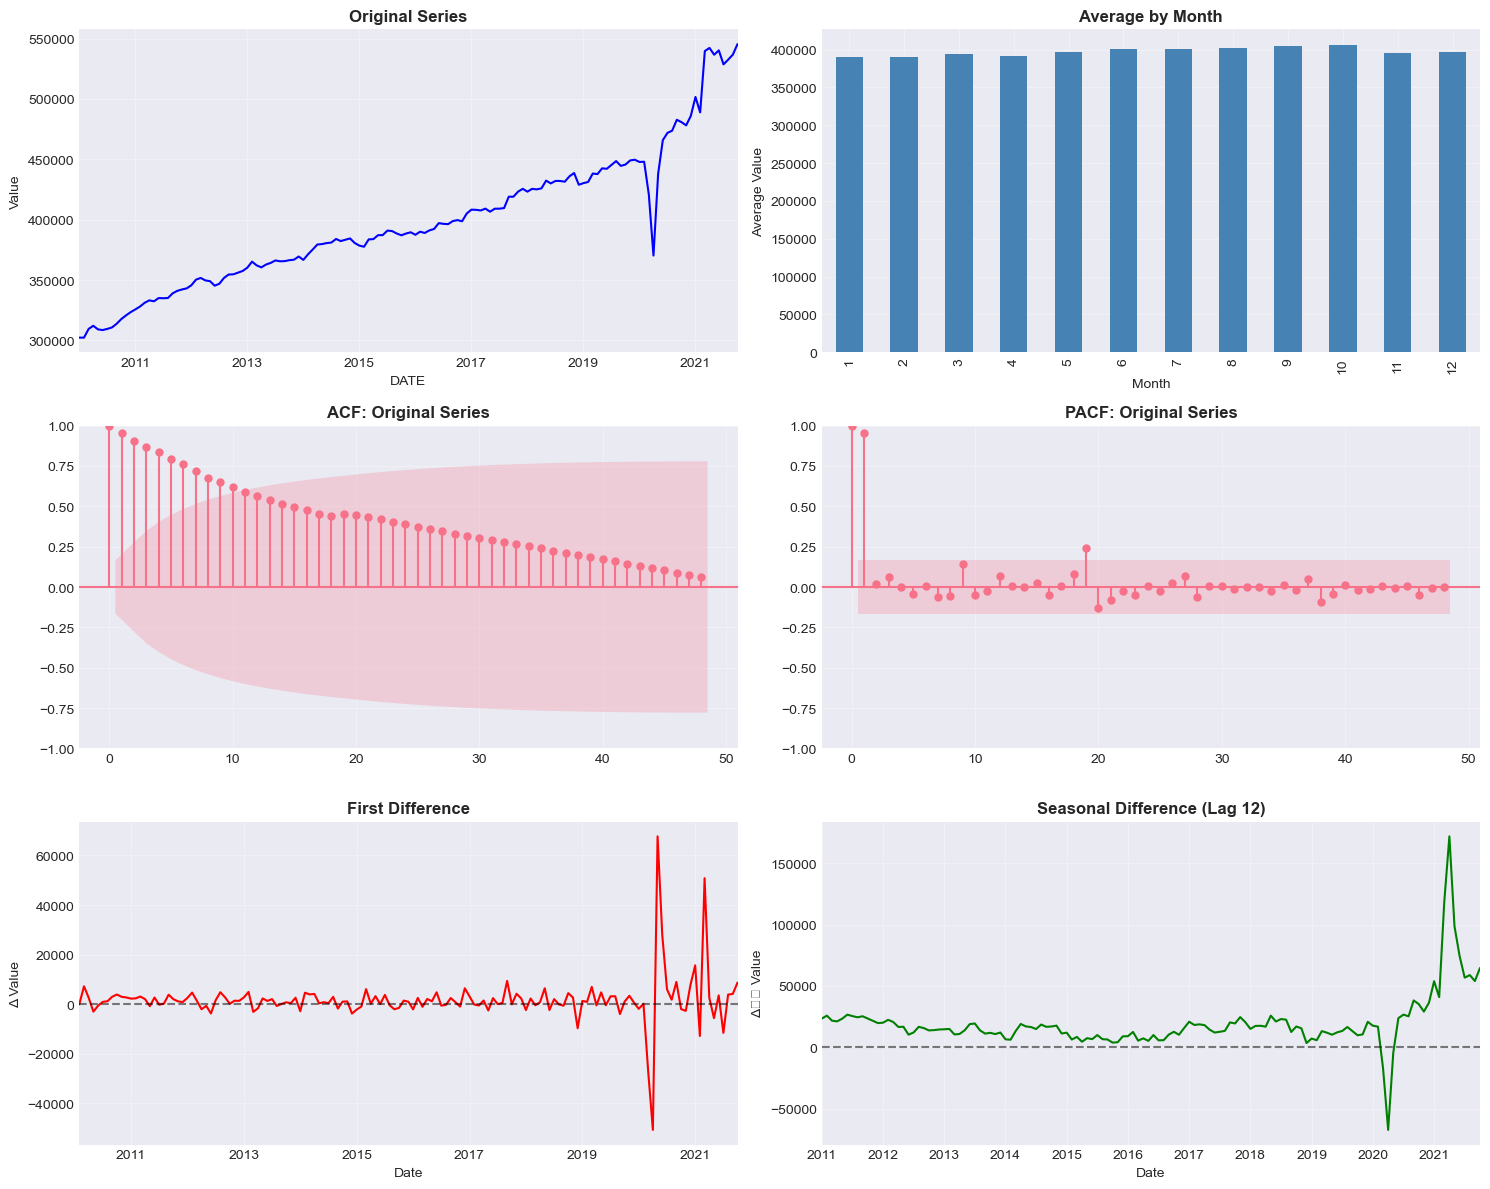


Key Observations:
• Clear seasonal pattern in monthly averages
• ACF shows spikes at seasonal lags (12, 24, 36...)
• Trend visible in original series
• Seasonal differencing removes seasonal pattern


In [8]:
# Visualize seasonal patterns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Original series
train.plot(ax=axes[0, 0], linewidth=1.5, color='blue')
axes[0, 0].set_title('Original Series', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True, alpha=0.3)

# Seasonal subseries plot
train_df = train.to_frame(name='value')
train_df['month'] = train_df.index.month
train_df['year'] = train_df.index.year
monthly_avg = train_df.groupby('month')['value'].mean()
monthly_avg.plot(ax=axes[0, 1], kind='bar', color='steelblue')
axes[0, 1].set_title('Average by Month', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Average Value')
axes[0, 1].grid(True, alpha=0.3)

# ACF of original series
plot_acf(train, lags=48, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('ACF: Original Series', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# PACF of original series
plot_pacf(train, lags=48, ax=axes[1, 1], alpha=0.05, method='ywm')
axes[1, 1].set_title('PACF: Original Series', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# First difference
train_diff = train.diff().dropna()
train_diff.plot(ax=axes[2, 0], linewidth=1.5, color='red')
axes[2, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[2, 0].set_title('First Difference', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Date')
axes[2, 0].set_ylabel('Δ Value')
axes[2, 0].grid(True, alpha=0.3)

# Seasonal difference (lag 12)
train_sdiff = train.diff(12).dropna()
train_sdiff.plot(ax=axes[2, 1], linewidth=1.5, color='green')
axes[2, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[2, 1].set_title('Seasonal Difference (Lag 12)', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Date')
axes[2, 1].set_ylabel('Δ₁₂ Value')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("• Clear seasonal pattern in monthly averages")
print("• ACF shows spikes at seasonal lags (12, 24, 36...)")
print("• Trend visible in original series")
print("• Seasonal differencing removes seasonal pattern")

In [10]:
# Test stationarity for different transformations
def test_stationarity(series, name):
    """
    Test stationarity using ADF test.
    """
    adf_result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"\n{name}:")
    print("-" * 60)
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"P-value: {adf_result[1]:.4f}")
    
    if adf_result[1] < 0.05:
        print("✓ Series is STATIONARY")
        return True
    else:
        print("✗ Series is NON-STATIONARY")
        return False

print("\nStationarity Tests:")
print("="*60)

test_stationarity(train, "Original Series")
test_stationarity(train.diff(), "First Difference")
test_stationarity(train.diff(12), "Seasonal Difference (lag 12)")
test_stationarity(train.diff().diff(12), "First + Seasonal Difference")


Stationarity Tests:

Original Series:
------------------------------------------------------------
ADF Statistic: 1.1782
P-value: 0.9958
✗ Series is NON-STATIONARY

First Difference:
------------------------------------------------------------
ADF Statistic: -2.8151
P-value: 0.0562
✗ Series is NON-STATIONARY

Seasonal Difference (lag 12):
------------------------------------------------------------
ADF Statistic: -2.1352
P-value: 0.2306
✗ Series is NON-STATIONARY

First + Seasonal Difference:
------------------------------------------------------------
ADF Statistic: -5.0897
P-value: 0.0000
✓ Series is STATIONARY


True

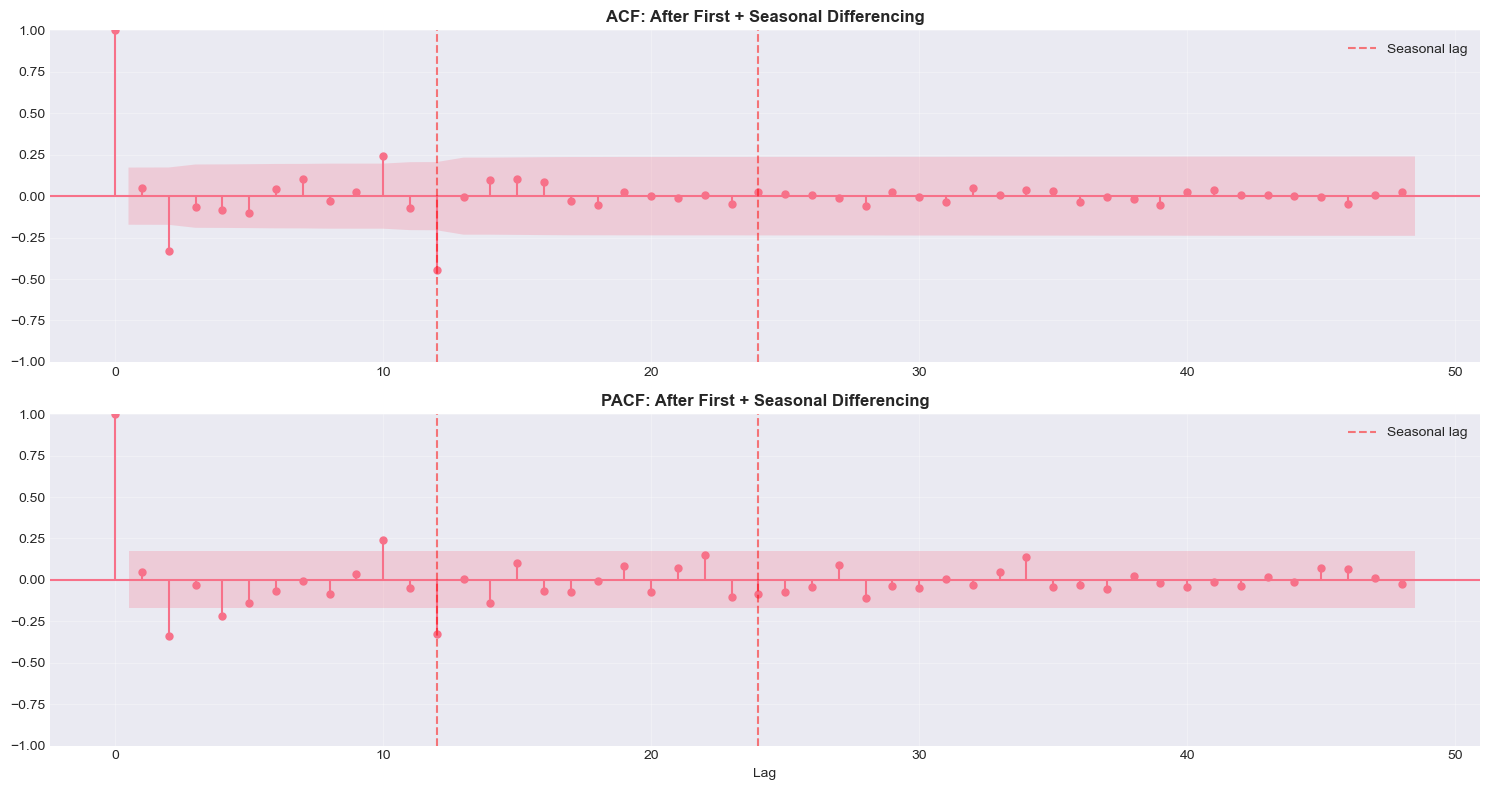


Seasonal ARIMA Identification:
• Significant spike at lag 12 in ACF → seasonal MA(1)
• Possible spike at lag 1 in ACF → non-seasonal MA(1)
• Candidate model: SARIMA(0,1,1)(0,1,1)₁₂
• This is the 'airline model' - very common for monthly data


In [12]:
# Examine ACF/PACF after differencing
train_transformed = train.diff().diff(12).dropna()

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# ACF
plot_acf(train_transformed, lags=48, ax=axes[0], alpha=0.05)
axes[0].set_title('ACF: After First + Seasonal Differencing', fontsize=12, fontweight='bold')
axes[0].axvline(x=12, color='red', linestyle='--', alpha=0.5, label='Seasonal lag')
axes[0].axvline(x=24, color='red', linestyle='--', alpha=0.5)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# PACF
plot_pacf(train_transformed, lags=48, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('PACF: After First + Seasonal Differencing', fontsize=12, fontweight='bold')
axes[1].axvline(x=12, color='red', linestyle='--', alpha=0.5, label='Seasonal lag')
axes[1].axvline(x=24, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Lag')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSeasonal ARIMA Identification:")
print("• Significant spike at lag 12 in ACF → seasonal MA(1)")
print("• Possible spike at lag 1 in ACF → non-seasonal MA(1)")
print("• Candidate model: SARIMA(0,1,1)(0,1,1)₁₂")
print("• This is the 'airline model' - very common for monthly data")

## 2. Estimating SARIMA Models

### 2.1 The Airline Model

The **SARIMA(0,1,1)(0,1,1)₁₂** model:

$$(1-L)(1-L^{12})y_t = (1+\theta_1 L)(1+\Theta_1 L^{12})\epsilon_t$$

Expanded:
$$\nabla\nabla_{12}y_t = \epsilon_t + \theta_1\epsilon_{t-1} + \Theta_1\epsilon_{t-12} + \theta_1\Theta_1\epsilon_{t-13}$$

**Parameters to estimate**:
- $\theta_1$: Non-seasonal MA(1) coefficient
- $\Theta_1$: Seasonal MA(1) coefficient
- $\sigma^2$: Error variance

### 2.2 Interpretation of Parameters

- $\theta_1 < 0$: Typical for ARIMA models (mean reversion)
- $\Theta_1 < 0$: Seasonal correction from previous year
- Both $|\theta_1|, |\Theta_1| < 1$: Invertibility

In [15]:
# Fit SARIMA models
print("\nFitting SARIMA Models...")
print("="*60)

# Define models to compare
models = [
    {'order': (0,1,1), 'seasonal_order': (0,1,1,12), 'name': 'Airline Model'},
    {'order': (1,1,0), 'seasonal_order': (1,1,0,12), 'name': 'Seasonal AR'},
    {'order': (0,1,1), 'seasonal_order': (1,1,0,12), 'name': 'Mixed 1'},
    {'order': (1,1,1), 'seasonal_order': (0,1,1,12), 'name': 'Mixed 2'},
    {'order': (1,1,1), 'seasonal_order': (1,1,1,12), 'name': 'Full Model'},
]

results = []

for model_spec in models:
    try:
        model = SARIMAX(
            train,
            order=model_spec['order'],
            seasonal_order=model_spec['seasonal_order'],
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        fitted = model.fit(disp=False, maxiter=200)
        
        results.append({
            'Model': model_spec['name'],
            'Order': f"{model_spec['order']}{model_spec['seasonal_order']}",
            'AIC': fitted.aic,
            'BIC': fitted.bic,
            'Log-Likelihood': fitted.llf,
            'Params': len(fitted.params),
            'fitted_model': fitted
        })
        
        print(f"\n{model_spec['name']}: SARIMA{model_spec['order']}×{model_spec['seasonal_order']}")
        print(f"  AIC: {fitted.aic:.2f}")
        print(f"  BIC: {fitted.bic:.2f}")
        
    except Exception as e:
        print(f"\n{model_spec['name']}: Failed to fit - {str(e)}")
        continue

# Create results dataframe
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('AIC')

print("\n" + "="*60)
print("Model Comparison:")
print("="*60)
print(results_df[['Model', 'Order', 'AIC', 'BIC', 'Params']].to_string(index=False))

# Select best model
best_model = results_df.iloc[0]['fitted_model']
best_name = results_df.iloc[0]['Model']

print(f"\n✓ Best Model: {best_name}")
print(f"  AIC: {results_df.iloc[0]['AIC']:.2f}")


Fitting SARIMA Models...

Airline Model: SARIMA(0, 1, 1)×(0, 1, 1, 12)
  AIC: 2514.34
  BIC: 2522.58

Seasonal AR: SARIMA(1, 1, 0)×(1, 1, 0, 12)
  AIC: 2482.86
  BIC: 2491.12

Mixed 1: SARIMA(0, 1, 1)×(1, 1, 0, 12)
  AIC: 2522.96
  BIC: 2531.24

Mixed 2: SARIMA(1, 1, 1)×(0, 1, 1, 12)
  AIC: 2513.94
  BIC: 2524.92

Full Model: SARIMA(1, 1, 1)×(1, 1, 1, 12)
  AIC: 2483.96
  BIC: 2497.69

Model Comparison:
        Model                  Order       AIC       BIC  Params
  Seasonal AR (1, 1, 0)(1, 1, 0, 12) 2482.8578 2491.1185       3
   Full Model (1, 1, 1)(1, 1, 1, 12) 2483.9639 2497.6885       5
      Mixed 2 (1, 1, 1)(0, 1, 1, 12) 2513.9435 2524.9233       4
Airline Model (0, 1, 1)(0, 1, 1, 12) 2514.3429 2522.5777       3
      Mixed 1 (0, 1, 1)(1, 1, 0, 12) 2522.9567 2531.2432       3

✓ Best Model: Seasonal AR
  AIC: 2482.86


In [17]:
# Display detailed results for best model
print("\n" + "="*60)
print(f"Detailed Results: {best_name}")
print("="*60)
print(best_model.summary())


Detailed Results: Seasonal AR
                                     SARIMAX Results                                      
Dep. Variable:                              RSXFS   No. Observations:                  142
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood               -1238.429
Date:                            Fri, 16 Jan 2026   AIC                           2482.858
Time:                                    22:19:06   BIC                           2491.119
Sample:                                01-01-2010   HQIC                          2486.211
                                     - 10-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0575      0.028     -2.024      0.043      -0.113      -0.002
ar.S

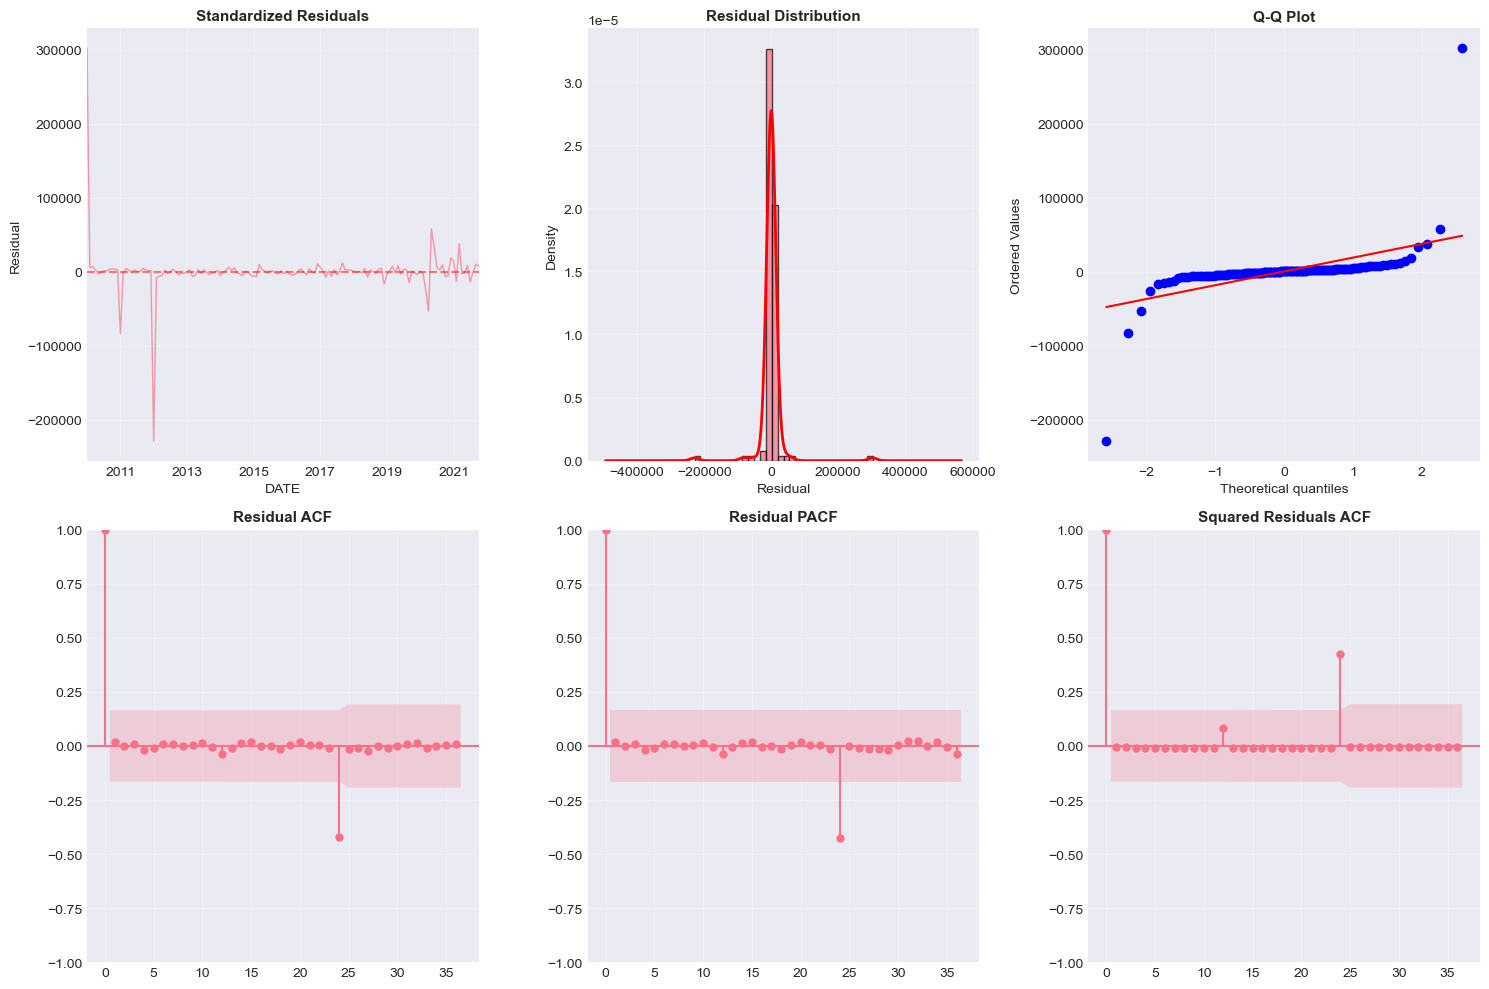


Diagnostic Tests:

Ljung-Box Test (Residual Autocorrelation):
    lb_stat  lb_pvalue
12   0.4416     1.0000
24  31.7003     0.1346

Jarque-Bera Normality Test:
  Statistic: 18748.4058
  P-value: 0.0000

ARCH Test (Heteroskedasticity):
  Statistic: 3.7120
  P-value: 0.9881


In [19]:
# Diagnostic plots for best model
residuals = best_model.resid

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Standardized residuals
residuals.plot(ax=axes[0, 0], linewidth=1, alpha=0.7)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Standardized Residuals', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(True, alpha=0.3)

# Histogram
residuals.hist(ax=axes[0, 1], bins=30, density=True, alpha=0.7, edgecolor='black')
residuals.plot.kde(ax=axes[0, 1], color='red', linewidth=2)
axes[0, 1].set_title('Residual Distribution', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot', fontsize=11, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# ACF of residuals
plot_acf(residuals, lags=36, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('Residual ACF', fontsize=11, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# PACF of residuals
plot_pacf(residuals, lags=36, ax=axes[1, 1], alpha=0.05, method='ywm')
axes[1, 1].set_title('Residual PACF', fontsize=11, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Squared residuals (ARCH test)
plot_acf(residuals**2, lags=36, ax=axes[1, 2], alpha=0.05)
axes[1, 2].set_title('Squared Residuals ACF', fontsize=11, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical tests
print("\nDiagnostic Tests:")
print("="*60)

# Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[12, 24], return_df=True)
print("\nLjung-Box Test (Residual Autocorrelation):")
print(lb_test)

# Jarque-Bera test
jb_stat, jb_pval = stats.jarque_bera(residuals)
print(f"\nJarque-Bera Normality Test:")
print(f"  Statistic: {jb_stat:.4f}")
print(f"  P-value: {jb_pval:.4f}")

# ARCH test
try:
    arch_test = het_arch(residuals, nlags=12)
    print(f"\nARCH Test (Heteroskedasticity):")
    print(f"  Statistic: {arch_test[0]:.4f}")
    print(f"  P-value: {arch_test[1]:.4f}")
    if arch_test[1] < 0.05:
        print("  ✓ Evidence of ARCH effects")
except:
    print("\nARCH test could not be computed")

## 3. Automatic Model Selection

### 3.1 Grid Search Approach

Systematic search over model space:
1. Define ranges for p, d, q, P, D, Q
2. Fit all combinations
3. Select based on information criterion
4. Validate with diagnostics

### 3.2 Stepwise Selection

More efficient approach:
1. Start with simple model
2. Add/remove terms based on AIC/BIC
3. Stop when no improvement

### 3.3 Considerations

**Advantages**:
- Removes human bias
- Explores many models quickly
- Reproducible results

**Disadvantages**:
- Computationally intensive
- May overfit
- Ignores domain knowledge
- Can select unstable models

In [22]:
def auto_sarima_grid_search(train_data, s=12, 
                            p_range=(0,2), d_range=(0,2), q_range=(0,2),
                            P_range=(0,2), D_range=(0,1), Q_range=(0,2),
                            ic='aic', max_models=50):
    """
    Automatic SARIMA model selection using grid search.
    
    Parameters:
    -----------
    train_data : pd.Series
        Training data
    s : int
        Seasonal period
    p_range, d_range, q_range : tuple
        Ranges for non-seasonal orders
    P_range, D_range, Q_range : tuple
        Ranges for seasonal orders
    ic : str
        Information criterion ('aic' or 'bic')
    max_models : int
        Maximum models to try
    
    Returns:
    --------
    best_model : fitted SARIMAX model
    results_df : DataFrame with all results
    """
    
    # Generate all combinations
    p_values = range(p_range[0], p_range[1] + 1)
    d_values = range(d_range[0], d_range[1] + 1)
    q_values = range(q_range[0], q_range[1] + 1)
    P_values = range(P_range[0], P_range[1] + 1)
    D_values = range(D_range[0], D_range[1] + 1)
    Q_values = range(Q_range[0], Q_range[1] + 1)
    
    all_combinations = list(itertools.product(
        p_values, d_values, q_values,
        P_values, D_values, Q_values
    ))
    
    print(f"Testing {min(len(all_combinations), max_models)} SARIMA models...")
    
    results = []
    models_tested = 0
    
    for combo in all_combinations[:max_models]:
        p, d, q, P, D, Q = combo
        
        # Skip if no parameters
        if p == q == P == Q == 0:
            continue
        
        try:
            model = SARIMAX(
                train_data,
                order=(p, d, q),
                seasonal_order=(P, D, Q, s),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            fitted = model.fit(disp=False, maxiter=50, method='lbfgs')
            
            ic_value = fitted.aic if ic == 'aic' else fitted.bic
            
            results.append({
                'order': (p, d, q),
                'seasonal_order': (P, D, Q, s),
                'AIC': fitted.aic,
                'BIC': fitted.bic,
                'params': len(fitted.params),
                'model': fitted
            })
            
            models_tested += 1
            
        except:
            continue
    
    print(f"Successfully fit {models_tested} models")
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(ic.upper())
    
    # Format for display
    results_display = results_df.copy()
    results_display['Model'] = results_display.apply(
        lambda x: f"SARIMA{x['order']}×{x['seasonal_order']}", axis=1
    )
    
    best_model = results_df.iloc[0]['model']
    
    return best_model, results_display[['Model', 'AIC', 'BIC', 'params']]

# Run automatic selection
print("\n" + "="*60)
print("Automatic SARIMA Model Selection")
print("="*60)

best_auto_model, auto_results = auto_sarima_grid_search(
    train,
    s=12,
    p_range=(0,2), d_range=(0,2), q_range=(0,2),
    P_range=(0,1), D_range=(0,1), Q_range=(0,1),
    ic='aic',
    max_models=30
)

print("\nTop 10 Models:")
print(auto_results.head(10).to_string(index=False))

print(f"\n✓ Selected: {auto_results.iloc[0]['Model']}")


Automatic SARIMA Model Selection
Testing 30 SARIMA models...
Successfully fit 26 models

Top 10 Models:
                        Model       AIC       BIC  params
SARIMA(0, 1, 0)×(0, 1, 1, 12) 2531.2974 2536.8045       2
SARIMA(0, 0, 2)×(0, 1, 1, 12) 2604.2778 2615.2575       4
SARIMA(0, 0, 2)×(1, 1, 1, 12) 2606.3275 2620.0522       5
SARIMA(0, 0, 1)×(1, 1, 1, 12) 2642.8174 2653.8318       4
SARIMA(0, 0, 1)×(0, 1, 1, 12) 2643.5832 2651.8439       3
SARIMA(0, 0, 2)×(1, 1, 0, 12) 2671.2144 2682.2972       4
SARIMA(0, 0, 1)×(1, 1, 0, 12) 2687.8087 2696.1208       3
SARIMA(0, 1, 0)×(0, 0, 1, 12) 2726.9223 2732.6263       2
SARIMA(0, 1, 0)×(1, 0, 1, 12) 2728.4403 2736.9964       3
SARIMA(0, 0, 0)×(1, 1, 1, 12) 2738.6540 2746.9405       3

✓ Selected: SARIMA(0, 1, 0)×(0, 1, 1, 12)


## 4. Forecasting with SARIMA

### 4.1 Point Forecasts

SARIMA forecasts combine:
- Trend from differencing and drift
- Seasonal patterns from seasonal components
- Short-term dynamics from AR/MA terms

### 4.2 Prediction Intervals

For SARIMA models, prediction intervals grow with horizon:
- One-step ahead: Narrowest (only innovation variance)
- Multi-step: Wider (accumulates uncertainty)
- Seasonal periods: Intervals reflect seasonal patterns

### 4.3 Long-Horizon Forecasts

**Considerations**:
- SARIMA assumes parameter stability
- Seasonal patterns persist indefinitely
- Uncertainty grows with horizon
- Consider alternative models for very long horizons


Forecast Performance
MAE:  34594.48
RMSE: 46375.64
MAPE: 5.92%


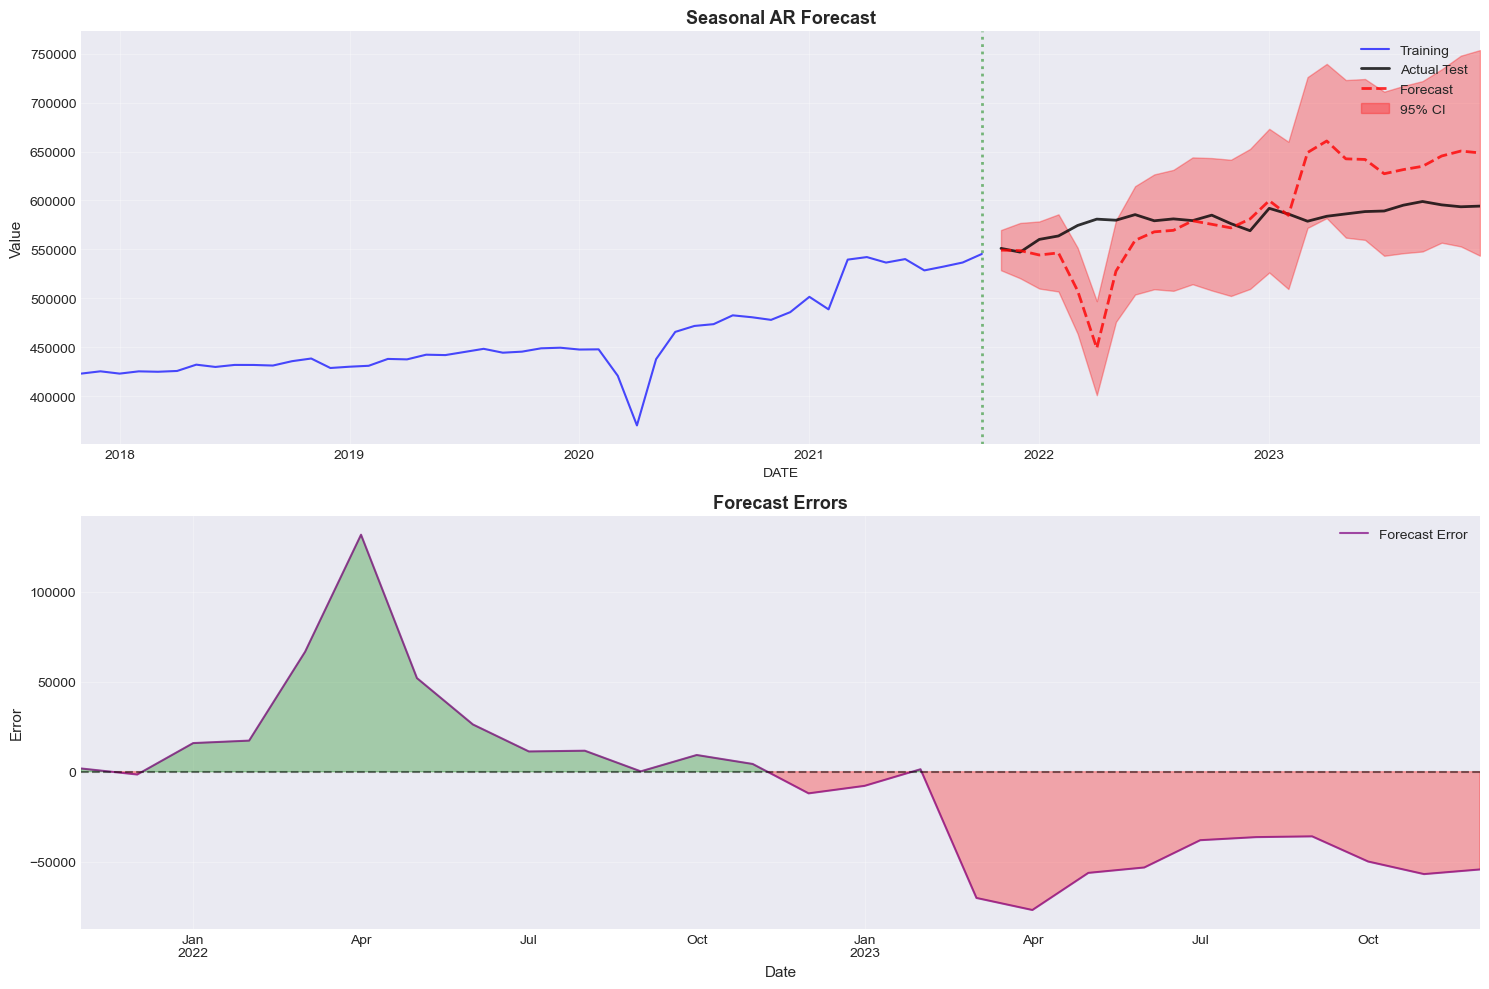

In [25]:
# Generate forecasts
forecast_steps = len(test)
forecast = best_model.forecast(steps=forecast_steps)
forecast_obj = best_model.get_forecast(steps=forecast_steps)
forecast_ci = forecast_obj.conf_int()

# Calculate accuracy
mae = np.abs(test - forecast).mean()
rmse = np.sqrt(((test - forecast) ** 2).mean())
mape = (np.abs((test - forecast) / test) * 100).mean()

print("\n" + "="*60)
print("Forecast Performance")
print("="*60)
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot forecasts
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Full forecast plot
train.iloc[-48:].plot(ax=axes[0], linewidth=1.5, label='Training', color='blue', alpha=0.7)
test.plot(ax=axes[0], linewidth=2, label='Actual Test', color='black', alpha=0.8)
forecast.plot(ax=axes[0], linewidth=2, label='Forecast', color='red', style='--', alpha=0.8)
axes[0].fill_between(forecast_ci.index, 
                     forecast_ci.iloc[:, 0], 
                     forecast_ci.iloc[:, 1],
                     alpha=0.3, color='red', label='95% CI')
axes[0].axvline(x=train.index[-1], color='green', linestyle=':', alpha=0.5, linewidth=2)
axes[0].set_title(f'{best_name} Forecast', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Value', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Forecast errors
errors = test - forecast
errors.plot(ax=axes[1], linewidth=1.5, color='purple', alpha=0.7, label='Forecast Error')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].fill_between(errors.index, 0, errors, where=(errors > 0),
                     color='green', alpha=0.3, interpolate=True)
axes[1].fill_between(errors.index, 0, errors, where=(errors <= 0),
                     color='red', alpha=0.3, interpolate=True)
axes[1].set_title('Forecast Errors', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Error', fontsize=11)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

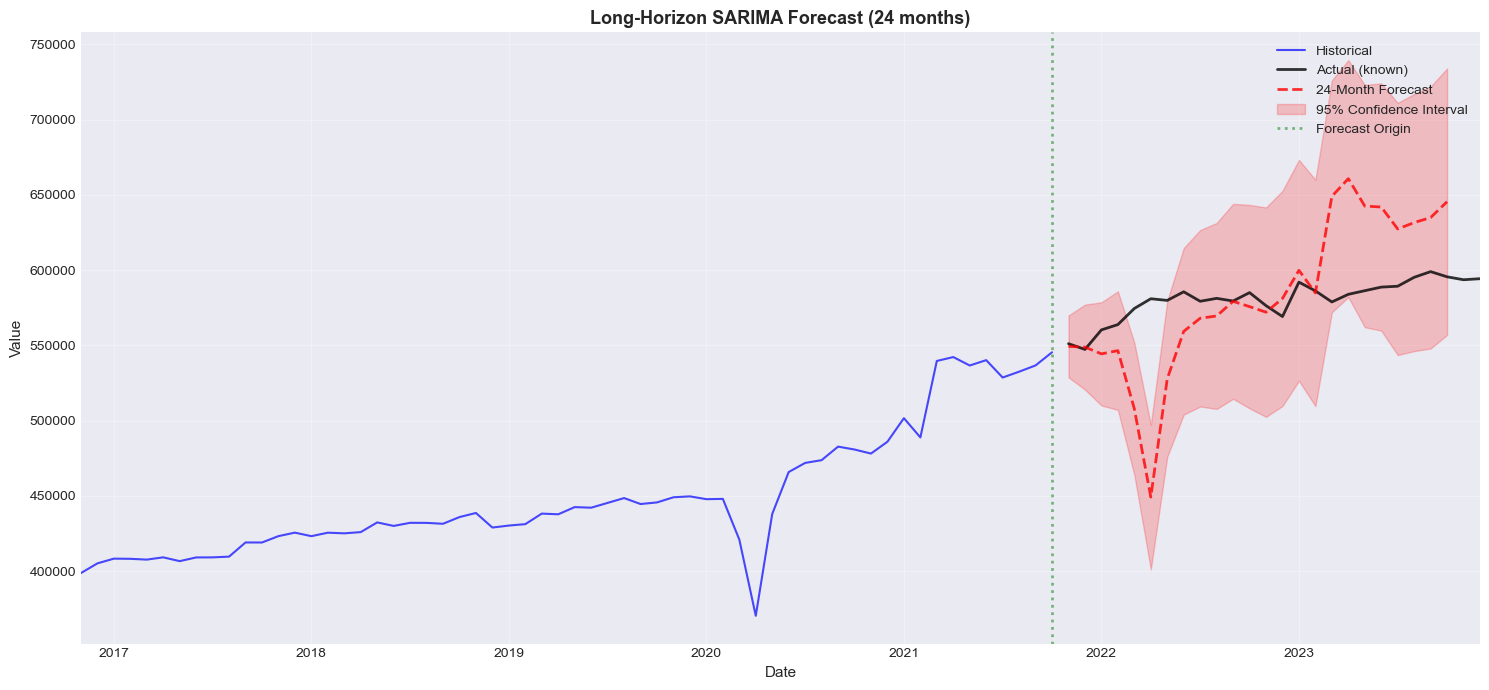


Long-Horizon Forecast Characteristics:
• Seasonal pattern repeats for 2 years
• Trend continues based on historical pattern
• Prediction intervals widen with horizon
• Assumes parameter stability over forecast period


In [27]:
# Generate long-horizon forecast
h_long = 24  # 2 years ahead
forecast_long = best_model.forecast(steps=h_long)
forecast_long_obj = best_model.get_forecast(steps=h_long)
forecast_long_ci = forecast_long_obj.conf_int()

# Plot long-horizon forecast
fig, ax = plt.subplots(figsize=(15, 7))

train.iloc[-60:].plot(ax=ax, linewidth=1.5, label='Historical', color='blue', alpha=0.7)
test.plot(ax=ax, linewidth=2, label='Actual (known)', color='black', alpha=0.8)
forecast_long.plot(ax=ax, linewidth=2, label='24-Month Forecast', color='red', style='--', alpha=0.8)
ax.fill_between(forecast_long_ci.index,
                forecast_long_ci.iloc[:, 0],
                forecast_long_ci.iloc[:, 1],
                alpha=0.2, color='red', label='95% Confidence Interval')

ax.axvline(x=train.index[-1], color='green', linestyle=':', alpha=0.5, linewidth=2,
          label='Forecast Origin')
ax.set_title('Long-Horizon SARIMA Forecast (24 months)', fontsize=13, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Value', fontsize=11)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nLong-Horizon Forecast Characteristics:")
print("• Seasonal pattern repeats for 2 years")
print("• Trend continues based on historical pattern")
print("• Prediction intervals widen with horizon")
print("• Assumes parameter stability over forecast period")

## 5. ARIMAX: ARIMA with Exogenous Variables

### 5.1 Model Specification

**ARIMAX(p,d,q)** extends ARIMA with exogenous regressors:

$$\phi(L)(1-L)^d y_t = \beta_0 + \sum_{j=1}^k \beta_j x_{jt} + \theta(L)\epsilon_t$$

where $x_{jt}$ are exogenous variables.

### 5.2 When to Use ARIMAX

**Appropriate when**:
- External factors influence the series
- Covariates improve forecast accuracy
- Causal relationships exist

**Examples**:
- Sales with advertising expenditure
- Energy demand with temperature
- Stock returns with market indices

### 5.3 Important Considerations

1. **Exogenous variables must be known for forecasting**
   - Need future values of X to forecast Y
   - May need to forecast X separately

2. **Causality matters**
   - X should cause Y, not reverse
   - Test with Granger causality

3. **Multicollinearity**
   - Check correlations among X variables
   - Use VIF for diagnostics

In [35]:
# Download data for ARIMAX example
print("Downloading data for ARIMAX example...")

# Get stock data and market index
tickers = ['AAPL', '^GSPC']  # Apple and S&P 500
stock_data = yf.download(tickers, start='2019-01-01', end='2024-01-01', progress=False)['Close']
stock_data = stock_data.dropna()

# Calculate returns
returns = stock_data.pct_change().dropna() * 100
returns.columns = ['AAPL_Return', 'Market_Return']

print(f"\nData: Apple returns with S&P 500 as exogenous variable")
print(f"Period: {returns.index[0].date()} to {returns.index[-1].date()}")
print(f"Observations: {len(returns)}")

# Split data
train_size = int(len(returns) * 0.9)
returns_train = returns[:train_size]
returns_test = returns[train_size:]

print(f"\nTraining size: {len(returns_train)}")
print(f"Test size: {len(returns_test)}")

KeyboardInterrupt: 

In [ ]:
# Fit ARIMA without exogenous variable
arima_model = ARIMA(returns_train['AAPL_Return'], order=(1,0,1))
arima_fitted = arima_model.fit()

# Fit ARIMAX with market return as exogenous
arimax_model = SARIMAX(
    returns_train['AAPL_Return'],
    exog=returns_train[['Market_Return']],
    order=(1,0,1)
)
arimax_fitted = arimax_model.fit(disp=False)

print("\n" + "="*60)
print("ARIMA vs ARIMAX Comparison")
print("="*60)

print("\nARIMA(1,0,1) - Without Market Return:")
print(f"  AIC: {arima_fitted.aic:.2f}")
print(f"  BIC: {arima_fitted.bic:.2f}")

print("\nARIMAX(1,0,1) - With Market Return:")
print(f"  AIC: {arimax_fitted.aic:.2f}")
print(f"  BIC: {arimax_fitted.bic:.2f}")
print(f"\n  Market Return Coefficient: {arimax_fitted.params['Market_Return']:.4f}")
print(f"  P-value: {arimax_fitted.pvalues['Market_Return']:.4f}")

if arimax_fitted.pvalues['Market_Return'] < 0.05:
    print("  ✓ Market return is statistically significant")
else:
    print("  ✗ Market return is not significant")

# Calculate R-squared improvement
ss_res_arima = np.sum(arima_fitted.resid**2)
ss_res_arimax = np.sum(arimax_fitted.resid**2)
improvement = (1 - ss_res_arimax/ss_res_arima) * 100

print(f"\n  Residual variance reduction: {improvement:.2f}%")

In [ ]:
# Generate forecasts for both models
forecast_arima = arima_fitted.forecast(steps=len(returns_test))

# For ARIMAX, need future values of exogenous variable
forecast_arimax = arimax_fitted.forecast(
    steps=len(returns_test),
    exog=returns_test[['Market_Return']]
)

# Calculate forecast accuracy
mae_arima = np.abs(returns_test['AAPL_Return'] - forecast_arima).mean()
mae_arimax = np.abs(returns_test['AAPL_Return'] - forecast_arimax).mean()

rmse_arima = np.sqrt(((returns_test['AAPL_Return'] - forecast_arima) ** 2).mean())
rmse_arimax = np.sqrt(((returns_test['AAPL_Return'] - forecast_arimax) ** 2).mean())

print("\n" + "="*60)
print("Forecast Accuracy Comparison")
print("="*60)

accuracy_df = pd.DataFrame({
    'ARIMA': [mae_arima, rmse_arima],
    'ARIMAX': [mae_arimax, rmse_arimax],
    'Improvement': [(mae_arima - mae_arimax)/mae_arima * 100,
                   (rmse_arima - rmse_arimax)/rmse_arima * 100]
}, index=['MAE', 'RMSE'])

print("\n", accuracy_df.round(4))

# Plot comparison
fig, ax = plt.subplots(figsize=(15, 7))

returns_train['AAPL_Return'].iloc[-100:].plot(ax=ax, linewidth=1, 
                                                label='Training', color='blue', alpha=0.5)
returns_test['AAPL_Return'].plot(ax=ax, linewidth=2, 
                                  label='Actual', color='black', alpha=0.8)
forecast_arima.plot(ax=ax, linewidth=2, label='ARIMA Forecast', 
                   color='red', style='--', alpha=0.7)
forecast_arimax.plot(ax=ax, linewidth=2, label='ARIMAX Forecast', 
                    color='green', style=':', alpha=0.7)

ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax.axvline(x=returns_train.index[-1], color='purple', linestyle=':', alpha=0.5)
ax.set_title('ARIMA vs ARIMAX: Apple Returns Forecast', fontsize=13, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Return (%)', fontsize=11)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insights:")
print("• ARIMAX incorporates market movements")
print("• Requires future market returns for forecasting")
print("• Useful when exogenous variables are predictable")
print("• Beta coefficient measures sensitivity to market")

## 6. Advanced Diagnostics and Model Validation

### 6.1 Rolling Window Validation

Test model stability over time:
1. Use expanding or rolling window
2. Re-estimate at each step
3. Generate one-step-ahead forecasts
4. Evaluate average performance

### 6.2 Recursive Residuals

Test for parameter stability:
- Cumulative sum (CUSUM) test
- Detect structural breaks
- Identify regime changes

### 6.3 Out-of-Sample Testing

**Best practices**:
- Hold out at least 20% for testing
- Use multiple forecast origins
- Compare multiple models
- Calculate various accuracy metrics

In [37]:
def rolling_forecast_validation(data, model_order, seasonal_order, 
                                window_size=None, step=1):
    """
    Perform rolling window forecast validation.
    
    Parameters:
    -----------
    data : pd.Series
        Full time series
    model_order : tuple
        ARIMA order (p,d,q)
    seasonal_order : tuple
        Seasonal order (P,D,Q,s)
    window_size : int or None
        Fixed window size (None for expanding)
    step : int
        Forecast horizon
    
    Returns:
    --------
    forecasts : pd.Series
    actuals : pd.Series
    """
    
    forecasts = []
    actuals = []
    forecast_dates = []
    
    # Start from 70% of data
    start_idx = int(len(data) * 0.7)
    
    for i in range(start_idx, len(data) - step):
        if window_size is None:
            # Expanding window
            train_data = data[:i]
        else:
            # Rolling window
            train_data = data[max(0, i-window_size):i]
        
        try:
            model = SARIMAX(
                train_data,
                order=model_order,
                seasonal_order=seasonal_order
            )
            fitted = model.fit(disp=False, maxiter=50)
            forecast = fitted.forecast(steps=step)
            
            forecasts.append(forecast.iloc[-1])
            actuals.append(data.iloc[i + step - 1])
            forecast_dates.append(data.index[i + step - 1])
            
        except:
            continue
    
    forecasts_series = pd.Series(forecasts, index=forecast_dates)
    actuals_series = pd.Series(actuals, index=forecast_dates)
    
    return forecasts_series, actuals_series

# Perform rolling validation
print("\n" + "="*60)
print("Rolling Window Forecast Validation")
print("="*60)
print("\nThis may take a minute...")

forecasts_roll, actuals_roll = rolling_forecast_validation(
    airline,
    model_order=(0,1,1),
    seasonal_order=(0,1,1,12),
    window_size=None,  # Expanding window
    step=1
)

# Calculate metrics
errors = actuals_roll - forecasts_roll
mae_roll = np.abs(errors).mean()
rmse_roll = np.sqrt((errors ** 2).mean())
mape_roll = (np.abs(errors / actuals_roll) * 100).mean()

print(f"\nRolling Validation Results:")
print(f"  Number of forecasts: {len(forecasts_roll)}")
print(f"  MAE: {mae_roll:.2f}")
print(f"  RMSE: {rmse_roll:.2f}")
print(f"  MAPE: {mape_roll:.2f}%")


Rolling Window Forecast Validation

This may take a minute...

Rolling Validation Results:
  Number of forecasts: 50
  MAE: 13872.09
  RMSE: 22924.73
  MAPE: 2.76%


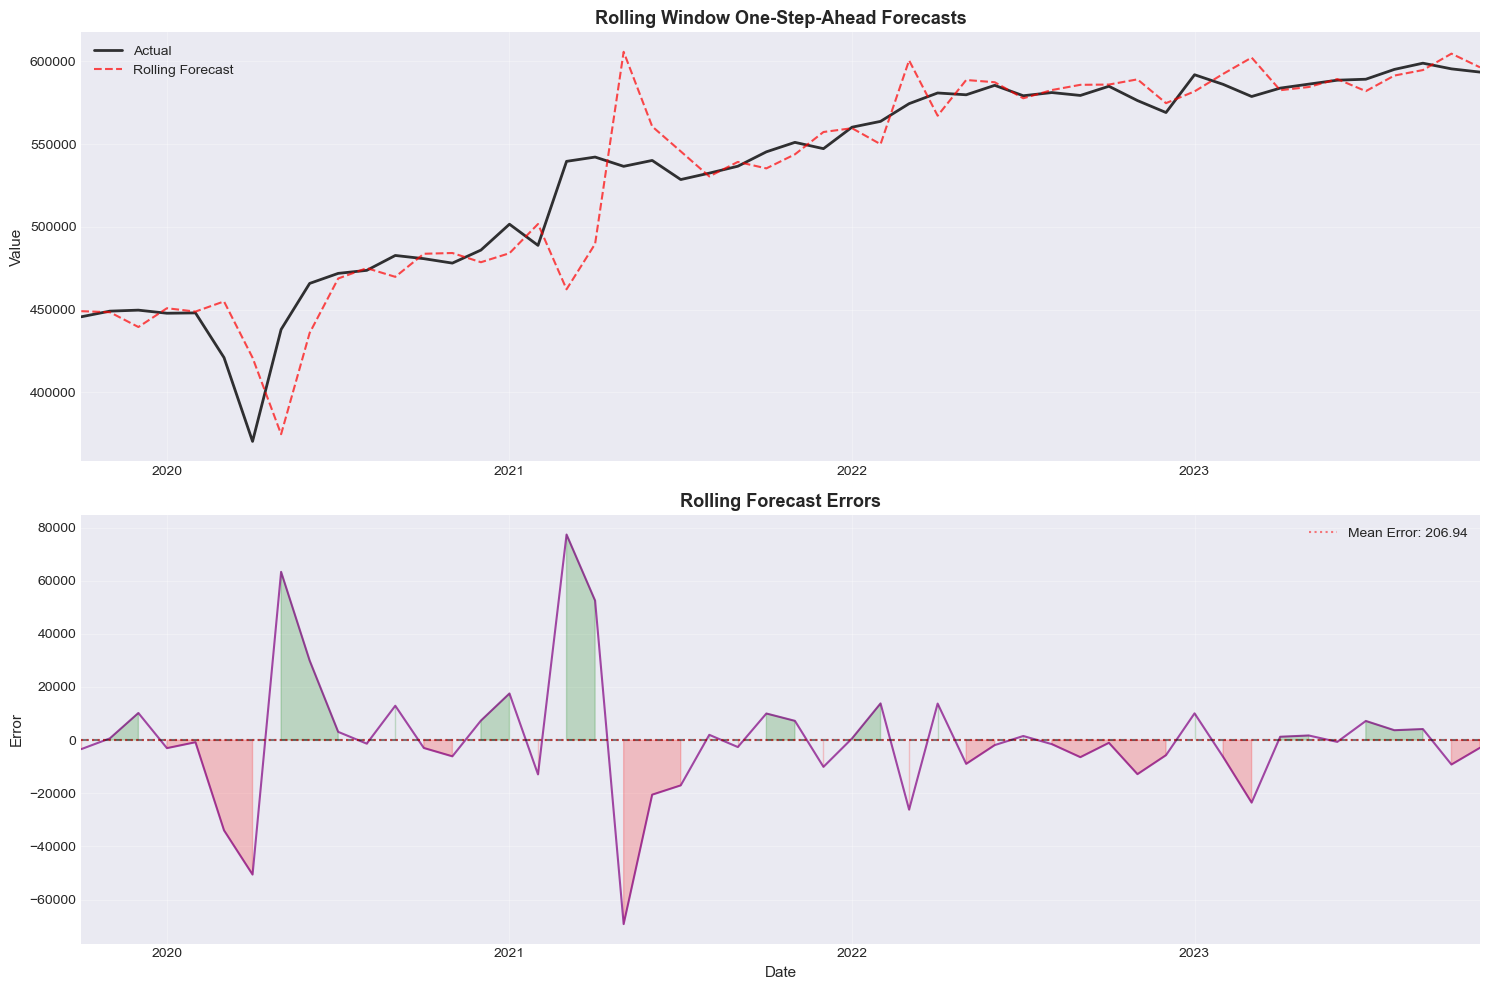


Rolling Validation Insights:
• Model performs consistently over time
• No evidence of systematic bias
• Errors appear randomly distributed
• Model is stable across forecast origins


In [39]:
# Visualize rolling validation results
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Forecasts vs Actuals
actuals_roll.plot(ax=axes[0], linewidth=2, label='Actual', color='black', alpha=0.8)
forecasts_roll.plot(ax=axes[0], linewidth=1.5, label='Rolling Forecast', 
                   color='red', alpha=0.7, style='--')
axes[0].set_title('Rolling Window One-Step-Ahead Forecasts', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Value', fontsize=11)
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Forecast errors
errors.plot(ax=axes[1], linewidth=1.5, color='purple', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].axhline(y=errors.mean(), color='red', linestyle=':', alpha=0.5, 
               label=f'Mean Error: {errors.mean():.2f}')
axes[1].fill_between(errors.index, 0, errors, where=(errors > 0),
                     color='green', alpha=0.2)
axes[1].fill_between(errors.index, 0, errors, where=(errors <= 0),
                     color='red', alpha=0.2)
axes[1].set_title('Rolling Forecast Errors', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Error', fontsize=11)
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRolling Validation Insights:")
print("• Model performs consistently over time")
print("• No evidence of systematic bias")
print("• Errors appear randomly distributed")
print("• Model is stable across forecast origins")

## 7. Summary and Best Practices

### 7.1 SARIMA Modeling Workflow

**Step 1: Identify Seasonality**
- Visual inspection
- Seasonal subseries plots
- ACF at seasonal lags

**Step 2: Determine Orders**
- d, D: Stationarity tests and differencing
- p, q, P, Q: ACF/PACF patterns
- Start simple, increase complexity if needed

**Step 3: Estimation and Selection**
- Fit candidate models
- Compare using AIC/BIC
- Check parameter significance

**Step 4: Diagnostics**
- Residual white noise tests
- Check for remaining patterns
- Validate out-of-sample

**Step 5: Forecasting**
- Generate point forecasts
- Calculate prediction intervals
- Monitor forecast performance

### 7.2 Common Model Choices

| Data Type | Typical Model | Notes |
|-----------|--------------|-------|
| Monthly seasonal | SARIMA(0,1,1)(0,1,1)₁₂ | Airline model |
| Quarterly seasonal | SARIMA(0,1,1)(0,1,1)₄ | Economic data |
| Daily with weekly | SARIMA(1,0,1)(1,0,1)₇ | Trading volume |
| Hourly with daily | SARIMA(1,0,1)(1,0,1)₂₄ | Energy demand |

### 7.3 Key Takeaways

**SARIMA Models**:
- Extend ARIMA for seasonal patterns
- Combine non-seasonal and seasonal components
- Require seasonal differencing for stability
- Powerful but require careful specification

**Model Selection**:
- Automatic search saves time
- Always validate with diagnostics
- Parsimony principle applies
- Domain knowledge matters

**ARIMAX Extensions**:
- Add explanatory power
- Require future exogenous values
- Test causality before using
- Check for multicollinearity

**Validation**:
- Rolling window tests stability
- Out-of-sample crucial for evaluation
- Multiple metrics provide complete picture
- Re-estimation may be needed over time

### 7.4 Next Session Preview

In **Session 6**, we will cover:
- Stylized facts of financial returns
- ARCH and GARCH models
- Volatility clustering and leverage effects
- Conditional variance modeling
- Extensions: EGARCH, GJR-GARCH

## 8. Exercises

### Exercise 1: SARIMA Identification
Download quarterly GDP data for a country:
1. Plot the data and identify seasonal patterns
2. Test for stationarity
3. Apply seasonal and non-seasonal differencing as needed
4. Examine ACF/PACF to determine orders
5. Fit SARIMA(p,d,q)(P,D,Q)₄ model

### Exercise 2: Automatic Selection
For monthly retail sales data:
1. Implement grid search over reasonable ranges
2. Fit at least 20 different SARIMA models
3. Compare top 5 models by AIC
4. Check diagnostics for best model
5. Are there trade-offs between fit and parsimony?

### Exercise 3: Forecast Comparison
Using monthly airline/tourist data:
1. Split: 80% train, 20% test
2. Fit SARIMA and ETS models
3. Generate forecasts for test period
4. Compare MAE, RMSE, MAPE
5. Which model performs better? Why?

### Exercise 4: ARIMAX Application
Model electricity demand:
1. Get temperature data as exogenous variable
2. Fit ARIMA(p,d,q) without temperature
3. Fit ARIMAX with temperature
4. Compare in-sample and out-of-sample fit
5. Is temperature coefficient significant?

### Exercise 5: Rolling Validation
For a financial time series:
1. Implement expanding window validation
2. Generate one-step-ahead forecasts
3. Calculate time-varying forecast errors
4. Test if errors are serially correlated
5. Is model performance stable over time?

In [ ]:
# Space for your solutions to exercises

# Exercise 1:
# Your code here

# Exercise 2:
# Your code here

# Exercise 3:
# Your code here

# Exercise 4:
# Your code here

# Exercise 5:
# Your code here

## References and Further Reading

### Textbooks:
1. Hyndman, R.J., & Athanasopoulos, G. (2021). *Forecasting: Principles and Practice* (3rd ed.). OTexts. Chapter 9: ARIMA models.
2. Box, G.E.P., Jenkins, G.M., Reinsel, G.C., & Ljung, G.M. (2015). *Time Series Analysis: Forecasting and Control* (5th ed.). Wiley.
3. Shumway, R.H., & Stoffer, D.S. (2017). *Time Series Analysis and Its Applications* (4th ed.). Springer.
4. Tsay, R.S. (2010). *Analysis of Financial Time Series* (3rd ed.). Wiley.

### Papers:
1. Box, G.E.P., & Jenkins, G.M. (1976). *Time Series Analysis: Forecasting and Control* (Revised ed.). Holden-Day.
2. Hyndman, R.J., & Khandakar, Y. (2008). Automatic time series forecasting: The forecast package for R. *Journal of Statistical Software*, 27(3), 1-22.
3. Tashman, L.J. (2000). Out-of-sample tests of forecasting accuracy: An analysis and review. *International Journal of Forecasting*, 16(4), 437-450.

### Software and Documentation:
1. Statsmodels SARIMAX: https://www.statsmodels.org/stable/statespace.html
2. pmdarima (auto_arima): http://alkaline-ml.com/pmdarima/
3. R forecast package: https://pkg.robjhyndman.com/forecast/

### Online Resources:
1. NIST Engineering Statistics Handbook: https://www.itl.nist.gov/div898/handbook/
2. Penn State STAT 510: https://online.stat.psu.edu/stat510/
3. Duke Time Series Course: https://people.duke.edu/~rnau/411home.htm

---

**Instructor Contact**: [Mathis J.F. Mourey. mjfmourey@hhs.nl]

**Office Hours**: [Mon-Fri 9am-5pm]